# SALES PREDICTION USING ARIMA AND PROPHET FOR BRAZILIAN E-COMMERCE

The dataset was generously provided by Olist, the largest department store in Brazilian marketplaces. Olist connects small businesses from all over Brazil to channels without hassle and with a single contract. Those merchants are able to sell their products through the Olist Store and ship them directly to the customers using Olist logistics partners. See more on our website: www.olist.com

After a customer purchases the product from Olist Store a seller gets notified to fulfill that order. Once the customer receives the product, or the estimated delivery date is due, the customer gets a satisfaction survey by email where he can give a note for the purchase experience and write down some comments.

**What is ARIMA model?**

A. ARIMA(Auto Regressive Integrated Moving Average) is a combination of 2 models AR(Auto Regressive) & MA(Moving Average). It has 3 hyperparameters - P(auto regressive lags),d(order of differentiation),Q(moving avg.) which respectively comes from the AR, I & MA components. The AR part is correlation between prev & current time periods. To smooth out the noise, the MA part is used. The I part binds together the AR & MA parts.

# 📤 IMPORT LIBRARIES

In [1]:
!pip install statsmodels
!pip install pmdarima

In [9]:
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot
from scipy import stats
import os
import itertools

import matplotlib.pyplot as plt
from matplotlib.gridspec import GridSpec
%matplotlib inline
pd.set_option('display.max_columns', 100)
from viz_utils import *

import seaborn as sns
import statsmodels.api as sm

from pylab import rcParams

from pmdarima import auto_arima
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.api import SARIMAX, AutoReg
from sklearn.metrics import mean_squared_error
from math import sqrt

# elimina os warnings das bibliotecas
import warnings
warnings.filterwarnings('ignore')


# 💾 CHECK OUT THE DATA

**IMPORTING AWS S3 BUCKET FILES**

In [3]:
orders = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_orders_dataset.csv"
customer = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_customers_dataset.csv"
item = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_items_dataset.csv"
products = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_products_dataset.csv"
sellers = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_sellers_dataset.csv"
order_pay = "https://stack-labs-landing.s3.amazonaws.com/datasets/olist_order_payments_dataset.csv"
category ="https://stack-labs-landing.s3.amazonaws.com/datasets/product_category_name_translation.csv"

In [4]:
df_orders = pd.read_csv(orders)
df_customers = pd.read_csv(customer)
df_item = pd.read_csv(item)
df_products = pd.read_csv(products)
df_sellers = pd.read_csv(sellers)
df_order_pay = pd.read_csv(order_pay)
df_category = pd.read_csv(category)

**MERGE DF_ORDERS WITH DF_CUSTOMERS**

In [5]:
df_orders = df_orders.merge(df_customers, on='customer_id', how='outer')

**ALL IN ONE**

In [6]:
# merge all the tables in one dataframe
df_train = df_orders.merge(df_item, on='order_id', how='left')
df_train = df_train.merge(df_order_pay, on='order_id', how='outer', validate='m:m')
df_train = df_train.merge(df_products, on='product_id', how='outer')
df_train = df_train.merge(df_sellers, on='seller_id', how='outer')

print(df_train.shape)

(118434, 33)


In [7]:
#This data from the train table will be used for the prediction of the price, which here we will call as total sales.
df_train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 118434 entries, 0 to 118433
Data columns (total 33 columns):
 #   Column                         Non-Null Count   Dtype  
---  ------                         --------------   -----  
 0   order_id                       118434 non-null  object 
 1   customer_id                    118434 non-null  object 
 2   order_status                   118434 non-null  object 
 3   order_purchase_timestamp       118434 non-null  object 
 4   order_approved_at              118258 non-null  object 
 5   order_delivered_carrier_date   116360 non-null  object 
 6   order_delivered_customer_date  115037 non-null  object 
 7   order_estimated_delivery_date  118434 non-null  object 
 8   customer_unique_id             118434 non-null  object 
 9   customer_zip_code_prefix       118434 non-null  int64  
 10  customer_city                  118434 non-null  object 
 11  customer_state                 118434 non-null  object 
 12  order_item_id                 

**CONVERT DATE COLUMNS TO TIMESTAMP**

In [11]:
# Changing the datetime features to the correct format
timestamp_cols = ['order_purchase_timestamp', 'order_approved_at', 'order_delivered_carrier_date', 'order_delivered_customer_date',
                  'order_estimated_delivery_date']
for col in timestamp_cols:
    df_orders[col] = pd.to_datetime(df_orders[col])
    
                  
# Extracting attributes for purchase date - Year and Month
df_orders['order_purchase_year'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.year)
df_orders['order_purchase_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.month)
#df_orders['order_purchase_month_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%b'))



df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m'))
df_orders['order_purchase_date'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m-%d'))

# Extracting attributes for purchase date - Year and Week
df_orders['order_purchase_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.week)
df_orders['order_purchase_year_week'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%U'))


# Extracting attributes for purchase date - Day and Day of Week
df_orders['order_purchase_day'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.day)
df_orders['order_purchase_dayofweek'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.dayofweek)
df_orders['order_purchase_dayofweek_name'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%a'))


# Extracting attributes for purchase date - Hour and Time of the Day
df_orders['order_purchase_hour'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.hour)
hours_bins = [-0.1, 6, 12, 18, 23]
hours_labels = ['Dawn', 'Morning', 'Afternoon', 'Night']
df_orders['order_purchase_time_day'] = pd.cut(df_orders['order_purchase_hour'], hours_bins, labels=hours_labels)

# New DataFrame after transformations
df_orders.head()

,order_id,customer_id,order_status,order_purchase_timestamp,order_approved_at,order_delivered_carrier_date,order_delivered_customer_date,order_estimated_delivery_date,customer_unique_id,customer_zip_code_prefix,customer_city,customer_state,order_purchase_year,order_purchase_month,order_purchase_year_month,order_purchase_date,order_purchase_week,order_purchase_year_week,order_purchase_day,order_purchase_dayofweek,order_purchase_dayofweek_name,order_purchase_hour,order_purchase_time_day
0,e481f51cbdc54678b7cc49136f2d6af7,9ef432eb6251297304e76186b10a928d,delivered,2017-10-02 10:56:00,2017-10-02 11:07:00,2017-10-04 19:55:00,2017-10-10 21:25:00,2017-10-18,7c396fd4830fd04220f754e42b4e5bff,3149,sao paulo,SP,2017,10,2017-10,2017-10-02,40,2017-40,2,0,Mon,10,Morning
1,53cdb2fc8bc7dce0b6741e2150273451,b0830fb4747a6c6d20dea0b8c802d7ef,delivered,2018-07-24 20:41:00,2018-07-26 03:24:00,2018-07-26 14:31:00,2018-08-07 15:27:00,2018-08-13,af07308b275d755c9edb36a90c618231,47813,barreiras,BA,2018,7,2018-07,2018-07-24,30,2018-29,24,1,Tue,20,Night
2,47770eb9100c2d0c44946d9cf07ec65d,41ce2a54c0b03bf3443c3d931a367089,delivered,2018-08-08 08:38:00,2018-08-08 08:55:00,2018-08-08 13:50:00,2018-08-17 18:06:00,2018-09-04,3a653a41f6f9fc3d2a113cf8398680e8,75265,vianopolis,GO,2018,8,2018-08,2018-08-08,32,2018-31,8,2,Wed,8,Morning
3,949d5b44dbf5de918fe9c16f97b45f8a,f88197465ea7920adcdbec7375364d82,delivered,2017-11-18 19:28:00,2017-11-18 19:45:00,2017-11-22 13:39:00,2017-12-02 00:28:00,2017-12-15,7c142cf63193a1473d2e66489a9ae977,59296,sao goncalo do amarante,RN,2017,11,2017-11,2017-11-18,46,2017-46,18,5,Sat,19,Night
4,ad21c59c0840e6cb83a9ceb5573f8159,8ab97904e6daea8866dbdbc4fb7aad2c,delivered,2018-02-13 21:18:00,2018-02-13 22:20:00,2018-02-14 19:46:00,2018-02-16 18:17:00,2018-02-26,72632f0f9dd73dfee390c9b22eb56dd6,9195,santo andre,SP,2018,2,2018-02,2018-02-13,7,2018-06,13,1,Tue,21,Night


In [ ]:
df_orders['order_purchase_year_month'] = df_orders['order_purchase_timestamp'].apply(lambda x: x.strftime('%Y-%m-%sd'))

In [ ]:
df_orders['order_purchase_week']

**CLEAN DATA**

In [ ]:
#Counting number of empty rows in the df_orders
df_orders.isnull().sum().sort_values(ascending = False)

In [ ]:
#Counting number of empty rows in the df_train
df_train.isnull().sum().sort_values(ascending = False)

In [ ]:
df_train.info()

**Is that a growing trend on e-commerce in Brazil? How can we describe a complete scenario?**

# **EXPLORATORY DATA ANALYSIS**

# **Visualization E-commerce Price Overtime**

# Price Distribution

In [ ]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Price Distributions', fontsize=22)
plt.subplot(221)
g = sns.histplot(df_train['price'], kde=True)
g.set_title("Price Distributions", fontsize=18)
g.set_xlabel("Price Values", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_train['price']), kde=True)
g1.set_title("Price(LOG) Distributions", fontsize=18)
g1.set_xlabel("Price Values", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.subplot(221)
res = stats.probplot(df_train['price'], plot=plt, fit=True, rvalue=True);

plt.subplot(222)
res = stats.probplot(np.log(df_train['price']), plot=plt, fit=True, rvalue=True);

plt.show()

Price Distribution: Histogram of a sample from a right-skewed distribution – it looks unimodal and skewed right.

Price Log Distribution: Histogram of a sample from a normal distribution – it looks fairly symmetric and unimodal.

Probability Plot - Price Distribution: Normal probability plot of a sample from a right-skewed distribution – it has an inverted C shape.

Probability Plot - Price Log Distribution: Normal probability plot of a sample from a normal distribution – it looks fairly straight, at least when the few large and small values are ignored.

# Visualization E-commerce Orders Overtime

# **Evolution of E-Commerce Overtime - Amount of orders**

In [ ]:
# Preparing the chart
fig, ax = plt.subplots(figsize=(10, 5))
ax = sns.countplot(x='order_purchase_year', data=df_orders, palette='Blues_d')
format_spines(ax, right_border=False)

# Showing frequency
ncount = len(df_orders)
for p in ax.patches:
    x=p.get_bbox().get_points()[:,0]
    y=p.get_bbox().get_points()[1,1]
    ax.annotate('{:.1f}%'.format(100.*y/ncount), (x.mean(), y), 
            ha='center', va='bottom', size=12)

ax.set_title('Amount of Online Order by Year', size=20)
ax.set_ylabel('Orders', size=18)
ax.set_xlabel('Year', size=18)

plt.tight_layout()
plt.show()

The number of orders in 2016 was insignificant, only 0,3% of the total.

Then, we selected the period of interest to try a better performance in the model

# **Evolution of E-Commerce Overtime - Total Sales per day**

In [ ]:
df_sale = df_train.groupby('order_purchase_timestamp')['price'].sum().reset_index()
df_sale['order_purchase_timestamp'] = pd.to_datetime(df_sale['order_purchase_timestamp'])
df_sale = df_sale.sort_values('order_purchase_timestamp')
df_sale.info()

**Analyzing the outliers**

In [ ]:
#Data Order Purchase Analysis
plt.figure(figsize=(25,10))
df_sale.plot.box(title='Order Purchase Sale Boxplot', vert=0);
plt.xlabel('Price')
plt.ylabel('');

In [ ]:
df_sale.isnull().sum()

In [ ]:
df_sale.info()

In [ ]:
df_sale.shape

In [ ]:
df_previsao = df_sale.set_index('order_purchase_timestamp')
    
df_previsao.info()

In [ ]:
# Test of stationarity.
# The null hypothesis reject (H0)= the series is not stationary
# If the p-value is less than 0.05, reject H0.

from statsmodels.tsa.stattools import adfuller

result=adfuller(df_previsao.dropna())
print(f'Teste ADF:{result[0]}')
print(f'p-valor:{result[1]}')

#  **Evolution of E-Commerce Overtime - Total Sales per month**

In [ ]:
#Resample time-series data to start month.
previsao = df_previsao['price'].resample('MS').sum()
previsao.fillna(df_previsao['price'].mean(), inplace=True)

In [ ]:
previsao.round(2)

In [ ]:
previsao.describe()

In [ ]:
previsao2 = previsao.replace(0.00, 5.489884e+05)
previsao2 = previsao2.replace(10.90, 5.489884e+05)
previsao3 = previsao2.drop(labels=['2018-09-01', '2018-10-01'])
previsao3.round(2)

In [ ]:
#formatar dado cientifico
previsao3.plot(figsize=(15, 6))
plt.xlabel("Month", size=18)
plt.ylabel("Total Sale", size=18)
plt.show()

As expected, the week with the order maximum was in the 47th week of 2017, when is the week known as Black Friday in Brazil. The minimum number of orders was in the first week of January 2018, a hangover period for purchases that took place at the end of year.

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(previsao3, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(previsao3,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

The above output suggests that the SARIMAX(0, 1, 0)x(0, 1, 0, 12)12 produces the lowest AIC value - AIC:110.35220622507379.

In [ ]:
df_previsao = df_sale.set_index('order_purchase_timestamp')

In [ ]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame

model_sarimax_previsao = SARIMAX(previsao3, order=(1,1,1), seasonal_order=(1,1,0,12), enforce_invertibility=False)
resultado_sarimax_previsao = model_sarimax_previsao.fit()
# summary of fit model
print(resultado_sarimax_previsao.summary())
resultado_sarimax_previsao.summary()

# line plot of residuals
residuals_previsao = DataFrame(resultado_sarimax_previsao.resid)
residuals_previsao.plot()
plt.show()
# density plot of residuals
residuals_previsao.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_previsao.describe())

In [ ]:
# VALIDATING THE FORECAST

pred_previsao = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred_previsao.conf_int()
ax = previsao3['2016':].plot(label='Actual')
pred_previsao.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Sale')
plt.title('Forecast vs Actuals', fontsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

From the chart, the SARIMAX(0, 1, 0)x(0, 1, 0, 12) model seems to give a directionally correct forecast. And the actual observed values lie within the 95% confidence band. That seems fine.

In [ ]:
previsao_forecasted = pred_previsao.predicted_mean
previsao3_truth = previsao3['2018-01-01':]
mse = ((previsao_forecasted - previsao3_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# 🔮 FINAL FORECAST - BY MONTH

In [ ]:
# Let’s forecast for the next 20 months.

pred_uc = results.get_forecast(steps=20)
pred_ci2 = pred_uc.conf_int()
ax = previsao3.plot(label='Actual', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()

# **Evolution of E-Commerce Overtime - Total Sales per week**

In [ ]:
#Sizing the table
plt.subplots(figsize=(15, 6))

# creating a weekly sales total price feature
df_sale['sales_weekly'] = df_sale['order_purchase_timestamp'].dt.strftime('%Y-%U')

# creating an aggregation
total_sales_weekly = df_sale.groupby('sales_weekly', as_index=False).price.sum()
ax = sns.lineplot(x="sales_weekly", y="price", data=total_sales_weekly)
ax.set_title('Sales per week', fontsize=20)
ax.set_ylabel('Sales Total Price', fontsize=18)
ax.set_xlabel('Order Purchase per Week', fontsize=18)
ax.set_xticks(ax.get_xticks()[::6])
plt.xticks(rotation=45);

As expected, the week with the order maximum was in the 47th week of 2017, when is the week known as Black Friday in Brazil. The minimum number of orders was in the first week of January 2018, a hangover period for purchases that took place at the end of year.

In [ ]:
#Resample time-series data to start month.
previsao4 = df_previsao['price'].resample('W-MON').sum()
previsao4.fillna(df_previsao['price'].mean(), inplace=True)

In [ ]:
previsao4.round(2)

In [ ]:
previsao4.describe()

In [ ]:
previsao5=previsao4.iloc[:-7]
previsao_w = previsao5.replace({0.000000: 127443.746875, 10.900000:127443.746875})
previsao_w[:20]

In [ ]:
previsao_w.plot(figsize=(15, 6))
plt.xlabel("Weekly", size=18)
plt.ylabel("Total Sale (R$)", size=18)
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(previsao_w, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            modweek = sm.tsa.statespace.SARIMAX(previsao_w,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = modweek.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

The above output suggests that the SARIMAX(1, 1, 0)x(1, 1, 1, 12)12 produces the lowest AIC:2282.9489510852254

In [ ]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame


model_sarimax_previsao = SARIMAX(previsao_w, order=(1,1,0), seasonal_order=(1,1,1,12), enforce_invertibility=False)
resultado_sarimax_previsao = model_sarimax_previsao.fit()
# summary of fit model
print(resultado_sarimax_previsao.summary())
resultado_sarimax_previsao.summary()

# line plot of residuals
residuals_previsao = DataFrame(resultado_sarimax_previsao.resid)
residuals_previsao.plot()
plt.show()
# density plot of residuals
residuals_previsao.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_previsao.describe())

In [ ]:
# VALIDATING THE FORECAST - weekly

pred_w = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred_w.conf_int()
ax = previsao_w['2016':].plot(label='Actual')
pred_w.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.title('Forecast vs Actuals', fontsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

In [ ]:
previsao_forecasted = pred_w.predicted_mean
previsao_w_truth = previsao_w['2018-01-01':]
mse = ((previsao_forecasted - previsao_w_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# 🔮 FINAL FORECAST - BY WEEK

In [ ]:
# # Let’s forecast for the next 40 weeks.

pred_uc = results.get_forecast(steps=40)
pred_ci2 = pred_uc.conf_int()
ax = previsao_w.plot(label='Actual', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()

# **Customer's State Distribution**

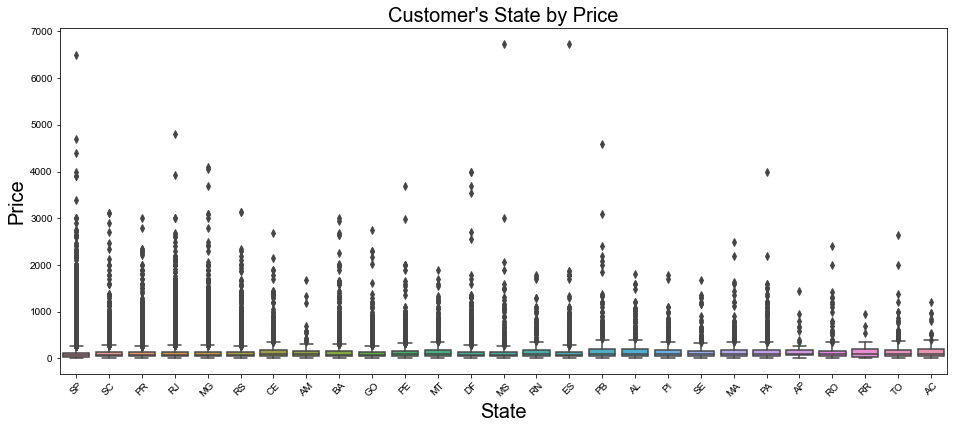

In [12]:
plt.figure(figsize=(35,14))

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Customer's State by Price", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

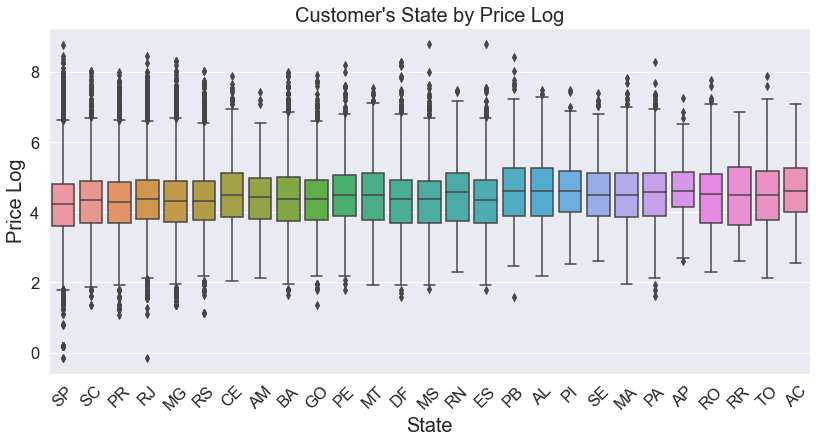

In [13]:
plt.figure(figsize=(30,14))
df_train['price_log'] = np.log(df_train['price'])

plt.subplot(221)
sns.set(font_scale=1.5) 
g2 = sns.boxplot(x='customer_state', y='price_log', 
                 data=df_train[df_train['price'] != -1])
g2.set_title("Customer's State by Price Log", fontsize=20)
g2.set_xlabel("State", fontsize=20)
g2.set_ylabel("Price Log", fontsize=20)
g2.set_xticklabels(g2.get_xticklabels(),rotation=45)

plt.show()

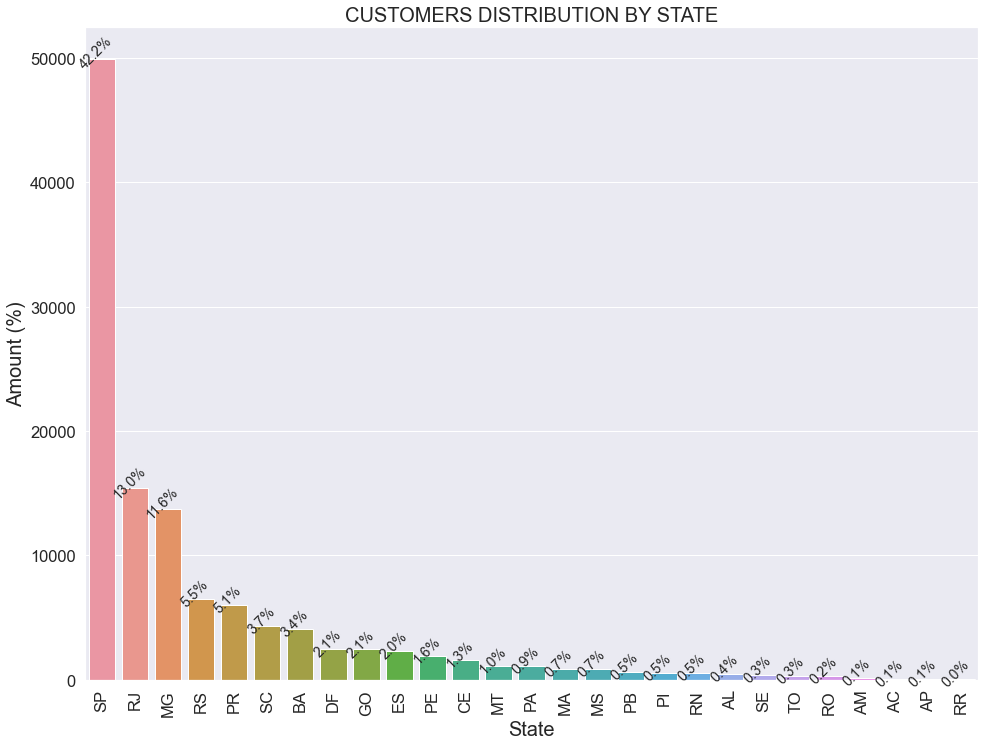

In [14]:
plt.figure(figsize=(16,12))

ax = sns.countplot(x='customer_state', data=df_train, orient='h', order=df_train['customer_state'].value_counts().index)
ax.set_title("CUSTOMERS DISTRIBUTION BY STATE", fontsize=20)
ax.set_xlabel("State", fontsize=20)
ax.set_ylabel("Amount (%)", fontsize=20)
ax.set_xticklabels(ax.get_xticklabels(),rotation=90)
sizes = []
total=len(df_train)

for p in ax.patches:
    percentage = f'{100 * p.get_height() / total:.1f}%\n'
    x = p.get_x() + p.get_width() / 2
    y = p.get_height()
    ax.annotate(percentage, (x, y), ha='center', va='center', fontsize=14, rotation=45)
    

plt.show()

# **Visualization E-commerce Purchase Order Overtime**

# **Purchase Order Distribution**

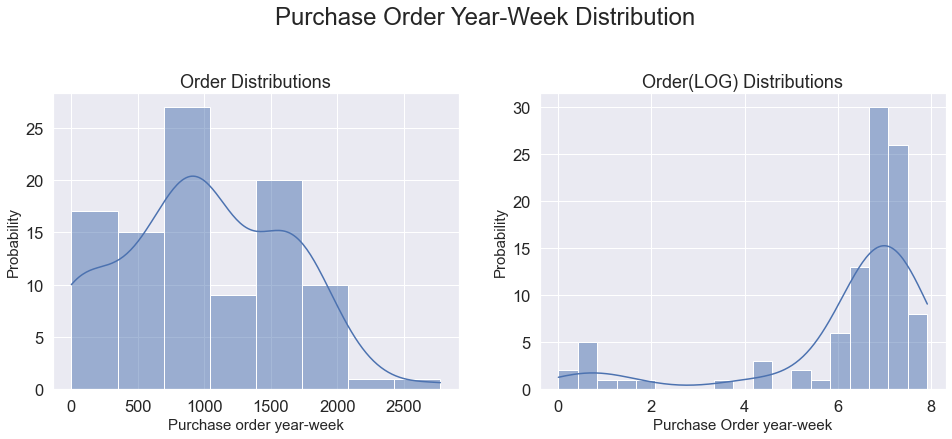

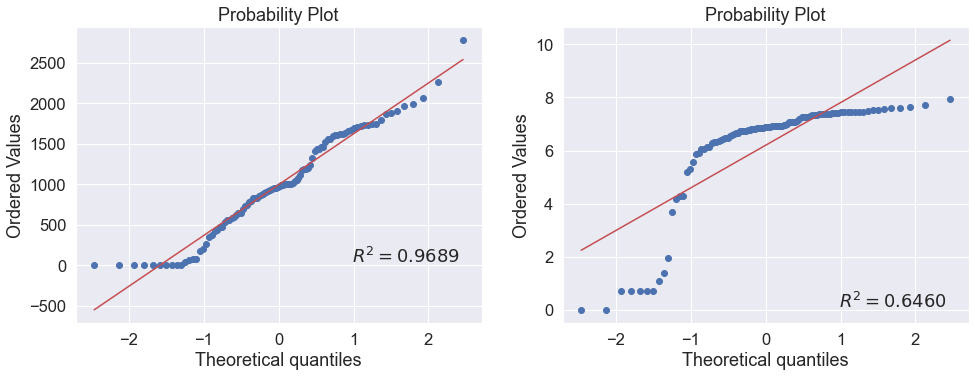

In [15]:
# Getting the histogram and normal probability plot
plt.figure(figsize=(16,12))
plt.suptitle('Purchase Order Year-Week Distribution', fontsize=24)
plt.subplot(221)
g = sns.histplot(df_orders['order_purchase_year_week'].value_counts(), kde=True)
g.set_title("Order Distributions", fontsize=18)
g.set_xlabel("Purchase order year-week", fontsize=15)
g.set_ylabel("Probability", fontsize=15)

plt.subplot(222)
g1 = sns.histplot(np.log(df_orders['order_purchase_year_week'].value_counts()), kde=True)
g1.set_title("Order(LOG) Distributions", fontsize=18)
g1.set_xlabel("Purchase Order year-week", fontsize=15)
g1.set_ylabel("Probability", fontsize=15)

plt.show()

plt.figure(figsize=(16,12))

plt.subplot(221)
res = stats.probplot(df_orders['order_purchase_year_week'].value_counts(), plot=plt, fit=True, rvalue=True);


plt.subplot(222)
res = stats.probplot(np.log(df_orders['order_purchase_year_week'].value_counts()), plot=plt, fit=True, rvalue=True);

plt.show()

**Purchase Order Distribution:**
Histogram of a sample from a  normal distribution – it looks fairly symmetric and bimodal.

**Price Log Distribution:**
Histogram of a sample from a right-skewed distribution – it looks unimodal and skewed right.

**Probability Plot - Price Distribution:**
Normal probability plot of a sample from a normal distribution – it looks fairly straight, at least when the few large and small values are ignored.

**Probability Plot - Price Log Distribution:**
Probability plot of a sample from a Right-skewed distribution – it looks fairly straight, at least when the few large and small values are ignored.

**Checking the minimum and maximum points of each dataframe date**

In [16]:
#number of orders per month of the year
df_orders_year_month=df_orders['order_purchase_year_month'].value_counts().sort_index()
#number of orders per year-week
df_orders_year_week=df_orders['order_purchase_year_week'].value_counts().sort_index()

In [17]:
df_orders['order_purchase_timestamp'].min(), df_orders['order_purchase_timestamp'].max()

(Timestamp('2016-09-04 21:15:00'), Timestamp('2018-10-17 17:30:00'))

# Evolution of E-Commerce Overtime - Total Orders per month

In [18]:
df_orders_year_month

2016-09       4
2016-10     324
2016-12       1
2017-01     800
2017-02    1780
2017-03    2682
2017-04    2404
2017-05    3700
2017-06    3245
2017-07    4026
2017-08    4331
2017-09    4285
2017-10    4631
2017-11    7544
2017-12    5673
2018-01    7269
2018-02    6728
2018-03    7211
2018-04    6939
2018-05    6873
2018-06    6167
2018-07    6292
2018-08    6512
2018-09      16
2018-10       4
Name: order_purchase_year_month, dtype: int64

In [34]:
# prepare expected column names - year-month
df_ym=pd.DataFrame({'ds':df_orders_year_month.index, 'y':df_orders_year_month.values})
df_ym.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 25 entries, 0 to 24
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   ds      25 non-null     object
 1   y       25 non-null     int64 
dtypes: int64(1), object(1)
memory usage: 528.0+ bytes


In [35]:
df_ym['ds'] = pd.to_datetime(df_ym['ds'])

In [36]:
df_ym = df_ym.replace(1, 800)
df_ym=df_ym[:23]
df_ym.set_index('ds', inplace = True)
df_ym.info()


<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 23 entries, 2016-09-01 to 2018-08-01
Data columns (total 1 columns):
 #   Column  Non-Null Count  Dtype
---  ------  --------------  -----
 0   y       23 non-null     int64
dtypes: int64(1)
memory usage: 368.0 bytes


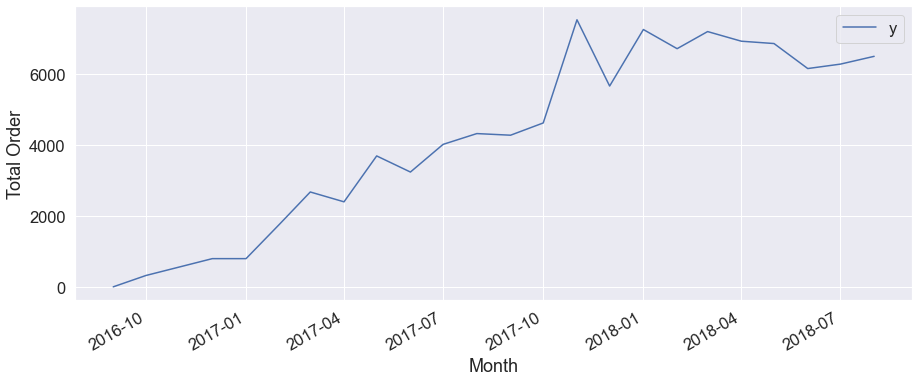

In [37]:
df_ym.plot(figsize=(15, 6))
plt.xlabel("Month", size=18)
plt.ylabel("Total Order", size=18)
plt.show()

In [39]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition2 = sm.tsa.seasonal_decompose(df_ym, model='additive')
fig = decomposition2.plot()
plt.show()

ValueError: You must specify a period or x must be a pandas object with a DatetimeIndex with a freq not set to None

In [33]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            mod = sm.tsa.statespace.SARIMAX(df_ym,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = mod.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

NameError: name 'pdq' is not defined

The above output suggests that the SARIMAX (1, 1, 0)x(0, 1, 0, 12)12 produces the lowest AIC value - AIC:205.1699

In [ ]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame


model_sarimax_previsao = SARIMAX(df_ym, order=(1,1,0), seasonal_order=(0,1,0,12), enforce_invertibility=False)
resultado_sarimax_previsao = model_sarimax_previsao.fit()
# summary of fit model
print(resultado_sarimax_previsao.summary())
resultado_sarimax_previsao.summary()

# line plot of residuals
residuals_previsao = DataFrame(resultado_sarimax_previsao.resid)
residuals_previsao.plot()
plt.show()
# density plot of residuals
residuals_previsao.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_previsao.describe())

In [ ]:
# VALIDATING THE FORECAST

pred_previsao = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred_previsao.conf_int()
ax = df_ym['2016':].plot(label='Actual')
pred_previsao.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data')
ax.set_ylabel('Order')
plt.title('Forecast vs Actuals', fontsize=20)
plt.legend(loc='upper left', fontsize=14)
plt.show()

In [ ]:
previsao_forecasted = pred_previsao.predicted_mean
df_ym_truth = df_ym['2018-01-01':]
mse = ((previsao_forecasted - df_ym_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

#  🔮 FINAL FORECAST - BY MONTH

In [ ]:
# Let’s forecast for the next 5 months.

pred_uc = results.get_forecast(steps=5)
pred_ci2 = pred_uc.conf_int()
ax = df_ym.plot(label='Actual', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Order', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()

In [ ]:
df_orders.set_index('order_purchase_timestamp', inplace=True)
prev = df_orders['order_purchase_timestamp'].resample('W-MON').mean()
prev

# Evolution of E-Commerce Overtime - Total Orders per week¶

In [ ]:
df_orders_year_week

In [ ]:
# prepare expected column names - year-month
df_yw=pd.DataFrame({'ds2':df_orders_year_week.index, 'y2':df_orders_year_week.values})
df_yw.set_index('ds2', inplace = True)
df_yw

In [ ]:
df_yw.plot(figsize=(15, 6))
plt.xlabel("Week", size=18)
plt.ylabel("Total Order", size=18)
plt.show()

In [ ]:
from pylab import rcParams
rcParams['figure.figsize'] = 18, 10
decomposition = sm.tsa.seasonal_decompose(df_yw, model='additive')
fig = decomposition.plot()
plt.show()

In [ ]:
warnings.filterwarnings("ignore") # specify to ignore warning messages

for param in pdq:
    for param_seasonal in seasonal_pdq:
        try:
            modweek = sm.tsa.statespace.SARIMAX(previsao_w,
                                            order=param,
                                            seasonal_order=param_seasonal,
                                            #enforce_stationarity=False,
                                            enforce_invertibility=False)

            results = modweek.fit()

            print('SARIMAX{}x{}12 - AIC:{}'.format(param, param_seasonal, results.aic))
        except:
            continue

In [ ]:
#Now, let's go create a SARIMAX model with seasonality (Arima version with parameters for seasonality)
from statsmodels.tsa.statespace.sarimax import SARIMAX
from pandas import DataFrame


model_sarimax_previsao = SARIMAX(df_yw, order=(1,1,1), seasonal_order=(0,1,1,12), enforce_invertibility=False)
resultado_sarimax_previsao = model_sarimax_previsao.fit()
# summary of fit model
print(resultado_sarimax_previsao.summary())
resultado_sarimax_previsao.summary()

# line plot of residuals
residuals_previsao = DataFrame(resultado_sarimax_previsao.resid)
residuals_previsao.plot()
plt.show()
# density plot of residuals
residuals_previsao.plot(kind='kde')
plt.show()
# summary stats of residuals
print(residuals_previsao.describe())

In [ ]:
# VALIDATING THE FORECAST - weekly

pred_w = results.get_prediction(start=pd.to_datetime('2018-01-01'), dynamic=False)
pred_ci = pred_w.conf_int()
ax = df_yw['2016':].plot(label='Actual')
pred_w.predicted_mean.plot(ax=ax, label='Forecast', alpha=.7, figsize=(14, 7))
ax.fill_between(pred_ci.index,
                pred_ci.iloc[:, 0],
                pred_ci.iloc[:, 1], color='k', alpha=.2)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.title('Forecast vs Actuals', fontsize=20)
plt.legend(loc='upper left', fontsize=18)
plt.show()

In [ ]:
previsao_forecasted = pred_w.predicted_mean
previsao_w_truth = previsao_w['2018-01-01':]
mse = ((previsao_forecasted - previsao_w_truth) ** 2).mean()
print('The Mean Squared Error of our forecasts is {}'.format(round(mse, 2)))

In [ ]:
print('The Root Mean Squared Error of our forecasts is {}'.format(round(np.sqrt(mse), 2)))

# 🔮 FINAL ORDERS FORECAST - BY WEEK

In [ ]:
# # Let’s forecast for the next 20 weeks.

pred_uc = results.get_forecast(steps=20)
pred_ci2 = pred_uc.conf_int()
ax = previsao_w.plot(label='Actual', figsize=(20, 10))
pred_uc.predicted_mean.plot(ax=ax, label='Forecast')
ax.fill_between(pred_ci2.index,
                pred_ci2.iloc[:, 0],
                pred_ci2.iloc[:, 1], color='k', alpha=.25)
ax.set_xlabel('Data', fontsize=18)
ax.set_ylabel('Sale', fontsize=18)
plt.legend(loc='upper left', fontsize=18)
plt.show()

**References:**

https://www.machinelearningplus.com/time-series/arima-model-time-series-forecasting-python

https://www.kaggle.com/thiagopanini/e-commerce-sentiment-analysis-eda-viz-nlp

https://www.linkedin.com/pulse/previs%25C3%25A3o-de-vendas-com-an%25C3%25A1lise-s%25C3%25A9ries-temporais-everton-s-paula/?trackingId=fRvgTUaEQCmaZhLGDBdG7A%3D%3D

https://github.com/ledmaster/notebooks_tutoriais/blob/master/live12_timeseries_prophet/nb1.ipynb

https://facebook.github.io/prophet/docs/quick_start.html#python-api

https://github.com/Pedro-Prestes/learning/blob/master/Aula_010_S%C3%A9ries_Temporais_com_Prophet.ipynb